In [33]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
df = pd.read_csv(r"https://raw.githubusercontent.com/alpsina/pi_intern_questions/main/dataset.csv")
df

,feature_1,feature_2,feature_3,feature_4,isVirus
0,-0.233467,0.308799,2.484015,1.732721,False
1,1.519003,1.238482,3.344450,0.783744,False
2,0.400640,1.916748,3.291096,-0.918519,False
3,-1.616474,0.209703,1.461544,-0.291837,False
4,1.480515,5.299829,2.640670,1.867559,True
...,...,...,...,...,...
1994,2.532559,2.139847,3.859104,2.190373,False
1995,NaN,3.562990,NaN,2.499590,False
1996,4.059027,1.977436,2.144760,4.257220,False
1997,3.457310,3.962342,3.770837,3.243168,False


In [35]:
#Since downloading a virus is much worse than not being able to download an app because it is labeled as one
#I will build a classification model that is going for recall and not precision
#User can download a trusted app if they wish so or trust the app but other is irreversible

In [36]:
#this is a function that I usually use for plotting numeric values
numerical_features = ["feature_1","feature_2","feature_3","feature_4"]
def numeric_plot(df, df_numeric):
    for f in df_numeric:
        fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.15, 0.85)})
        ax_box.grid(alpha=0.75)
        ax_hist.grid(alpha=0.75)
        flierprops = dict(
            markerfacecolor="r", markersize=2, linestyle="none", markeredgecolor="r"
        )
        sns.boxplot(df[f], orient="h", ax=ax_box, flierprops=flierprops)
        sns.histplot(df[f], ax=ax_hist, bins=50, kde=True)

        # Remove x axis name for the boxplot
        ax_box.set(xlabel="")
        plt.show()

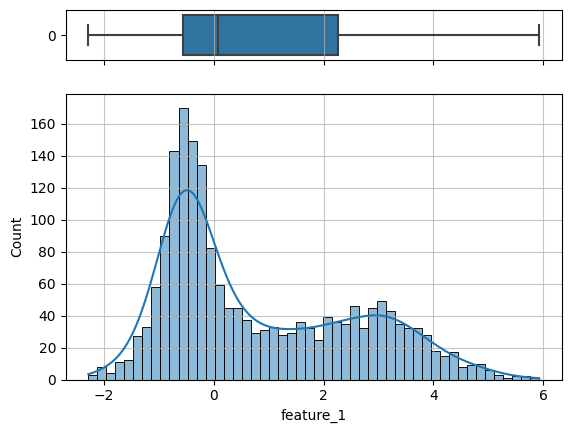

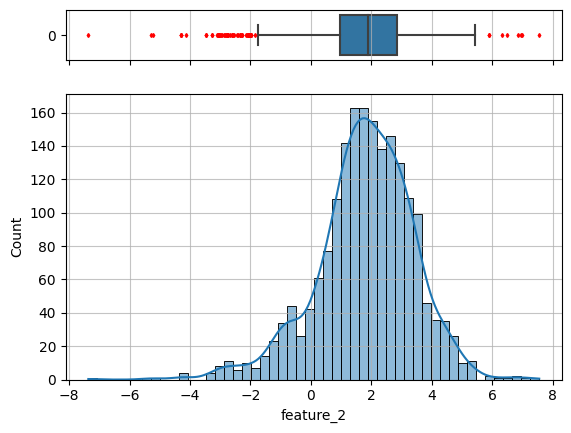

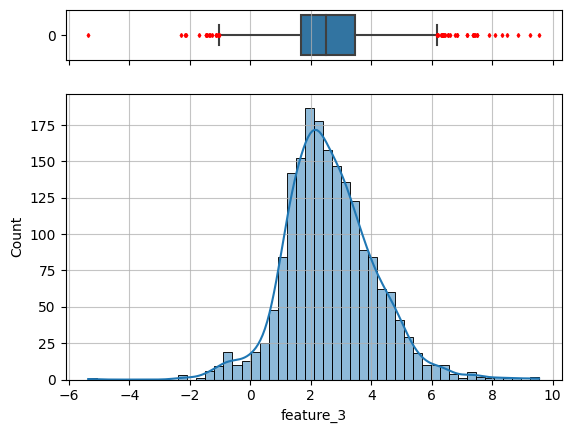

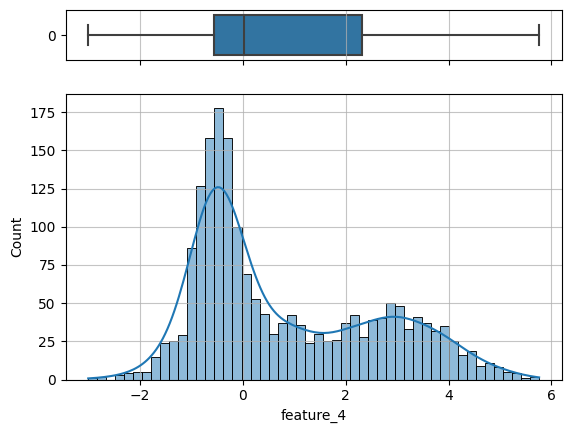

In [37]:
numeric_plot(df, numerical_features)

In [ ]:
#distributiaons look just fine no need for any log scaling

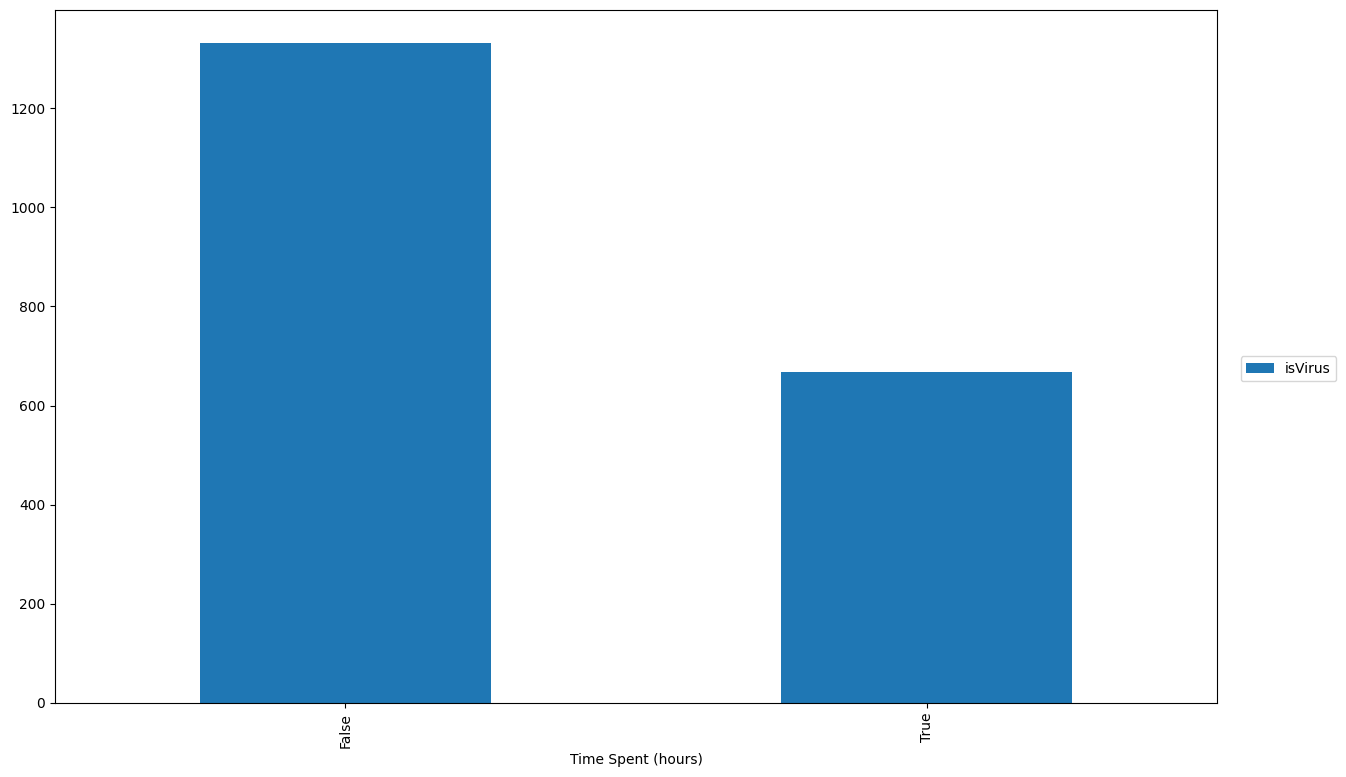

In [38]:
cmap = plt.get_cmap("Set1")
fig = df["isVirus"].value_counts().plot(kind="bar")
fig.figure.set_size_inches(15, 9)
fig.set_title("")
fig.set_xlabel("Time Spent (hours)")
fig.set_ylabel("")
fig.legend(bbox_to_anchor=(1.02, 0.5), loc='upper left', borderaxespad=0)


In [39]:
#it looks like we got enough of both classes and one doesn't outnumber the other significantly
#I don't think we need to do a more balanced subset to train our models

In [40]:
df.info()
#we have some missing values since we don't have many points to begin with we should just fill them so we don't lose points

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  1897 non-null   float64
 1   feature_2  1899 non-null   float64
 2   feature_3  1893 non-null   float64
 3   feature_4  1897 non-null   float64
 4   isVirus    1999 non-null   bool   
dtypes: bool(1), float64(4)
memory usage: 64.5 KB


In [41]:
df["feature_1"].fillna(value=df["feature_1"].mean(), inplace=True)
df["feature_2"].fillna(value=df["feature_2"].mean(), inplace=True)
df["feature_3"].fillna(value=df["feature_3"].mean(), inplace=True)
df["feature_4"].fillna(value=df["feature_4"].mean(), inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  1999 non-null   float64
 1   feature_2  1999 non-null   float64
 2   feature_3  1999 non-null   float64
 3   feature_4  1999 non-null   float64
 4   isVirus    1999 non-null   bool   
dtypes: bool(1), float64(4)
memory usage: 64.5 KB


In [43]:
#I will use outlier detection and removel
#This is also a function that I use frequently
def clean_outliers(df, df_numeric):
    print(len(df))
    for f in df_numeric:
        q1 = df[f].quantile(0.25)
        q3 = df[f].quantile(0.75)
        iqr = q3 - q1
        upper_limit = q3 + iqr *1.5
        lower_limit = q1 - iqr *1.5
        new_df = df.loc[((df[f]<upper_limit) & (df[f]>lower_limit))]
    print(len(new_df), len(df)-len(new_df))
    df = new_df
clean_outliers(df,numerical_features)

1999
1999 0


In [44]:
#There aren't any, great! Our dataset was already small

In [45]:
#Let's start building models
#import
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import HistGradientBoostingClassifier

In [58]:
target = df["isVirus"]
X_values = df.drop(["isVirus"], axis="columns")
X_values = StandardScaler().fit_transform(X_values)#scaling makes models work better, basically it puts each value between 1 and 0

In [59]:
#we separete a small part of the data to test our model
x_train, x_test, y_train, y_test = train_test_split(X_values, target, random_state=42, stratify=target, test_size=0.2)
#we will not touch our test data until the very end otherwise it will be like train data and will create bias

In [60]:

# Define parameter grids so we can find the best ones with random searching
# I use distributions in a given interval so there is a higher chance of finding local minimas with random search
param_grids = {
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': np.linspace(50, 150, 11, dtype=int),
            'max_depth': [None] + np.linspace(10, 20, 4, dtype=int).tolist(),
            'min_samples_split': np.linspace(2, 10, 5, dtype=int),
            'min_samples_leaf': np.linspace(1, 4, 4, dtype=int),
            'bootstrap': [True, False]
        }
    },
    'DecisionTreeClassifier': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': [None] + np.linspace(10, 20, 4, dtype=int).tolist(),
            'min_samples_split': np.linspace(2, 10, 5, dtype=int),
            'min_samples_leaf': np.linspace(1, 4, 4, dtype=int)
        }
    },
    'HistGradientBoostingClassifier': {
        'model': HistGradientBoostingClassifier(),
        'param_grid': {
            'learning_rate': np.linspace(0.01, 0.2, 10),
            'max_iter': np.linspace(50, 150, 11, dtype=int),
            'max_leaf_nodes': np.linspace(15, 63, 7, dtype=int),
            'min_samples_leaf': np.linspace(20, 80, 7, dtype=int),
            'l2_regularization': np.linspace(0.0, 0.2, 5)
        }
    },
    'XGBClassifier': {
        'model': XGBClassifier(),
        'param_grid': {
            'max_depth': [3, 5, 7],
            'learning_rate': np.linspace(0.01, 0.2, 10),
            'n_estimators': np.linspace(50, 150, 11, dtype=int),
            'gamma': np.linspace(0, 0.2, 5),
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': np.linspace(0, 0.5, 6),
            'reg_lambda': [1.0, 2.0, 5.0]
        }
    }
}

parameter_dict = []

# Perform RandomizedSearchCV for each classifier and record the best parameters 
#since our dataset is small we can do lots of iterations
#and save the best ones
for name, config in param_grids.items():
    print(f"Running RandomizedSearchCV for {name}")
    random_search = RandomizedSearchCV(estimator=config['model'], param_distributions=config['param_grid'], n_iter=250, cv=3, verbose=2, random_state=42, n_jobs=-1, scoring="recall")
    random_search.fit(x_train, y_train)  # Replace X_train and y_train with your data
    q = [name, random_search.best_params_, random_search.best_score_]
    parameter_dict.append(q)


Running RandomizedSearchCV for RandomForestClassifier
Fitting 3 folds for each of 250 candidates, totalling 750 fits
Running RandomizedSearchCV for DecisionTreeClassifier
Fitting 3 folds for each of 250 candidates, totalling 750 fits
Running RandomizedSearchCV for HistGradientBoostingClassifier
Fitting 3 folds for each of 250 candidates, totalling 750 fits
Running RandomizedSearchCV for XGBClassifier
Fitting 3 folds for each of 250 candidates, totalling 750 fits


In [67]:
random_search.best_estimator_ #what our best model looks like

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1577777777777778,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [68]:
random_search.best_score_ #what is the score it get

0.8164794007490638

In [69]:
parameter_dict#This is where we keep the info from our best estimators

[['RandomForestClassifier',
  {'n_estimators': 50,
   'min_samples_split': 6,
   'min_samples_leaf': 1,
   'max_depth': 13,
   'bootstrap': False},
  0.8071161048689138],
 ['DecisionTreeClassifier',
  {'splitter': 'best',
   'min_samples_split': 4,
   'min_samples_leaf': 1,
   'max_depth': 13,
   'criterion': 'entropy'},
  0.8333333333333334],
 ['HistGradientBoostingClassifier',
  {'min_samples_leaf': 50,
   'max_leaf_nodes': 15,
   'max_iter': 100,
   'learning_rate': 0.07333333333333333,
   'l2_regularization': 0.2},
  0.7940074906367042],
 ['XGBClassifier',
  {'subsample': 1.0,
   'reg_lambda': 2.0,
   'reg_alpha': 0.2,
   'n_estimators': 100,
   'max_depth': 5,
   'learning_rate': 0.1577777777777778,
   'gamma': 0.1,
   'colsample_bytree': 1.0},
  0.8164794007490638]]

In [70]:
parameter_dict[0][1] #I am checking the list indexing to make sure I got the correct element

{'n_estimators': 50,
 'min_samples_split': 6,
 'min_samples_leaf': 1,
 'max_depth': 13,
 'bootstrap': False}

In [71]:
clf1 = RandomForestClassifier(**{'n_estimators': 60,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 16,
 'bootstrap': False})
clf2 = DecisionTreeClassifier(**parameter_dict[1][1])
clf3 = HistGradientBoostingClassifier(**parameter_dict[2][1])
clf4 = XGBClassifier(**parameter_dict[3][1])
voting_classifier= VotingClassifier(estimators=[('rf', clf1), ('dt', clf2), ('hgnb', clf3), ("xgbc",clf4)], voting='hard')
voting_classifier.fit(x_train, y_train)
#This voting classifier takes the estimate that is agreed upon by the majority of models
#Since all our models are trained to the best parameters and have similar scores it is usefull to use all of them
#A voting classifier always works better if the classifiers perform better than random guessing at the first place

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=16,
                                                     n_estimators=60)),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=13,
                                                     min_samples_split=4)),
                             ('hgnb',
                              HistGradientBoostingClassifier(l2_regularization=0.2,
                                                             learning_rate=0.07333333333333333,
                                                             max_leaf_nodes=15,
                                                             min_samples_leaf=50)),
                             ('xgbc',
                              XGBClassifier(base...
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1577777777777778,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...))])

In [73]:
y_pred = voting_classifier.predict(x_test) #let's make predictions with the test data we put aside

Text(0.5, 1.0, 'Confusion Matrix')

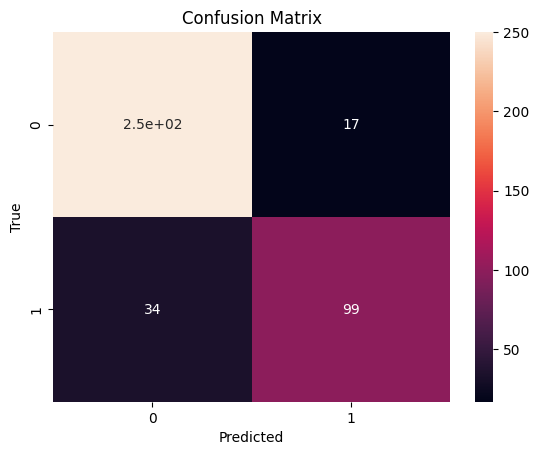

In [78]:
#I am setting up a table where we can evaluate our models performance easily
from sklearn.metrics import confusion_matrix 
conf = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig = sns.heatmap(conf, annot=True)
fig.set_xlabel("Predicted")
fig.set_ylabel("True")
fig.set_title("Confusion Matrix")

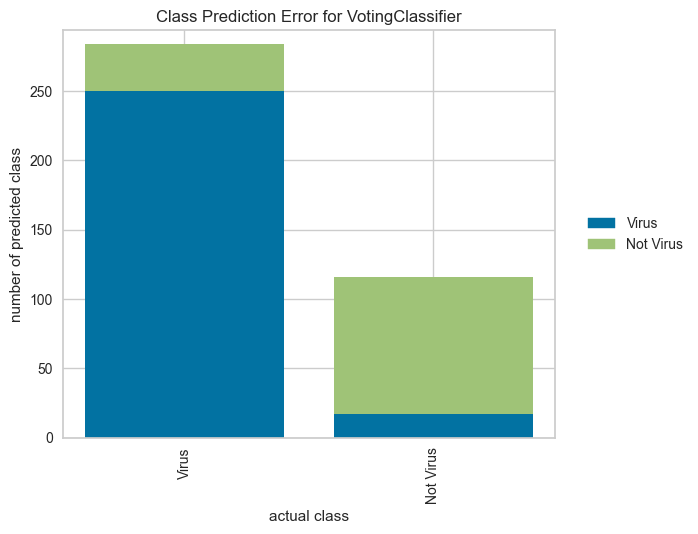

<AxesSubplot: title={'center': 'Class Prediction Error for VotingClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [82]:
from yellowbrick.classifier import ClassPredictionError
visualizer = ClassPredictionError(
    voting_classifier,  classes=["Virus", "Not Virus"]
)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()
#Another way to see our models performance

In [ ]:
#Model falsly put 34 non virus apps to the virus category
#Model falsyy put 17 virus apps as non virus
#I think overall we achived our goal of recall without sacrificing much precision

What could be done to improve our models:
-We need more data
-We can always add classifiers and bigger iteration numbers though I don't think this would increase our score significantly
-We could build a neural network but I think we don't need one for a simpler task like this.